In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 7))

In [10]:
rand_sub_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271])

In [11]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [12]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [13]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [14]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [15]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

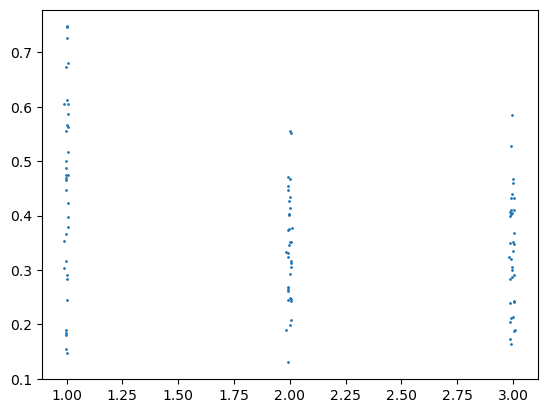

In [16]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [17]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [18]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(105, 3)


In [19]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [20]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [23]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.97it/s]


Loss: 403.1127768405713
Average Loss: 0.055160478494878394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.43it/s]


Loss: 403.1520019117743
Average Loss: 0.05516584591020447
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.50it/s]


Loss: 403.15142926271074
Average Loss: 0.055165767551000375
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.93it/s]


Loss: 403.02127104392275
Average Loss: 0.05514795717623464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.77it/s]


Loss: 403.04441282711923
Average Loss: 0.055151123813234705
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.51it/s]


Loss: 403.02352546714246
Average Loss: 0.05514826566326525
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.04it/s]


Loss: 403.12454595416784
Average Loss: 0.05516208893735192
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.63it/s]


Loss: 403.1151372762397
Average Loss: 0.055160801488264875
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.36it/s]


Loss: 402.9775572242215
Average Loss: 0.055141975536976126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.23it/s]


Loss: 402.9365737333428
Average Loss: 0.05513636750593087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|███▏                                                                                                                                                          | 149/7308 [00:02<00:47, 150.62it/s]

X_batch: 
torch.Size([128, 105])
tensor([[0.5685, 0.3054, 0.5260,  ..., 0.7950, 0.3971, 0.4232],
        [0.4323, 0.2178, 0.2104,  ..., 0.4677, 0.1371, 0.2442],
        [0.3648, 0.2492, 0.3732,  ..., 0.4626, 0.1564, 0.2514],
        ...,
        [0.3612, 0.2171, 0.1902,  ..., 0.4273, 0.1396, 0.2176],
        [0.5937, 0.3148, 0.2679,  ..., 0.6827, 0.1035, 0.3817],
        [0.3385, 0.2091, 0.4096,  ..., 0.6973, 0.1203, 0.3329]])
X_pred: 
torch.Size([128, 105])
tensor([[0.5522, 0.4275, 0.4083,  ..., 0.6064, 0.3429, 0.4325],
        [0.4586, 0.2419, 0.1763,  ..., 0.4562, 0.1566, 0.2517],
        [0.4226, 0.1964, 0.2857,  ..., 0.4170, 0.1217, 0.2835],
        ...,
        [0.3988, 0.1864, 0.1696,  ..., 0.3948, 0.1183, 0.2064],
        [0.5249, 0.2811, 0.2800,  ..., 0.5606, 0.0709, 0.4071],
        [0.4312, 0.1764, 0.4635,  ..., 0.5390, 0.0719, 0.2915]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.04it/s]


Loss: 402.9310400246177
Average Loss: 0.055135610293461645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.92it/s]


Loss: 402.9732038099319
Average Loss: 0.05514137983168198
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.99it/s]


Loss: 402.929599477211
Average Loss: 0.05513541317422154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.12it/s]


Loss: 402.9612371348776
Average Loss: 0.055139742355620906
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.87it/s]


Loss: 402.88704236829653
Average Loss: 0.05512958981503784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.23it/s]


Loss: 402.9407224729657
Average Loss: 0.05513693520429197
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.21it/s]


Loss: 402.97488293237984
Average Loss: 0.05514160959665843
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.51it/s]


Loss: 402.8552036229521
Average Loss: 0.055125233117535866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.99it/s]


Loss: 402.85738080437295
Average Loss: 0.05512553103508114
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.57it/s]


Loss: 402.93374235206284
Average Loss: 0.055135980070068806
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.48it/s]


Loss: 402.8096399453934
Average Loss: 0.055118998350491714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.08it/s]


Loss: 402.8028744184412
Average Loss: 0.05511807258052014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.13it/s]


Loss: 402.78435042570345
Average Loss: 0.05511553782508257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.77it/s]


Loss: 402.8626897614449
Average Loss: 0.0551262574933559
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.02it/s]


Loss: 402.7705193092115
Average Loss: 0.055113645225672074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.82it/s]


Loss: 402.83076751674525
Average Loss: 0.05512188937010745
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.55it/s]


Loss: 402.8016436332837
Average Loss: 0.05511790416437926
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.16it/s]


Loss: 402.7352299375925
Average Loss: 0.0551088163570871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.16it/s]


Loss: 402.9123220744077
Average Loss: 0.055133048997592735
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.25it/s]


Loss: 402.8027459208388
Average Loss: 0.05511805499737805
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.82it/s]


Loss: 402.7805087850429
Average Loss: 0.05511501214902065
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.41it/s]


Loss: 402.9189421564806
Average Loss: 0.055133954865418805
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.18it/s]


Loss: 402.86499081435613
Average Loss: 0.05512657236102301
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.46it/s]


Loss: 402.6713079113979
Average Loss: 0.055100069500738626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.76it/s]


Loss: 402.8227806885261
Average Loss: 0.05512079648173592
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.22it/s]


Loss: 402.6519268830307
Average Loss: 0.055097417471679073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.63it/s]


Loss: 402.65527189080603
Average Loss: 0.05509787519031281
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.58it/s]


Loss: 402.7213286801707
Average Loss: 0.055106914159848204
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.22it/s]


Loss: 402.62603088491596
Average Loss: 0.055093873957979746
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.61it/s]


Loss: 402.6341222252231
Average Loss: 0.05509498114740327
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.88it/s]


Loss: 402.7326153968461
Average Loss: 0.05510845859289082
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.25it/s]


Loss: 402.78748683212325
Average Loss: 0.055115966999469516
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.33it/s]


Loss: 402.6773822873365
Average Loss: 0.05510090069613253
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.48it/s]


Loss: 402.72559771779925
Average Loss: 0.05510749831934856
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.13it/s]


Loss: 402.65508537366986
Average Loss: 0.055097849667989855
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.43it/s]


Loss: 402.6518333130516
Average Loss: 0.055097404667905255
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.54it/s]


Loss: 402.5723626338877
Average Loss: 0.05508653019073449
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.60it/s]


Loss: 402.6542703353334
Average Loss: 0.0550977381411239
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.42it/s]


Loss: 402.7083071398083
Average Loss: 0.05510513233987525
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.38it/s]


Loss: 402.5614688859787
Average Loss: 0.055085039530101076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.89it/s]


Loss: 402.63869350682944
Average Loss: 0.055095606664864454
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.60it/s]


Loss: 402.519448637031
Average Loss: 0.055079289632872334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.40it/s]


Loss: 402.61089626397006
Average Loss: 0.055091802991785725
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.43it/s]


Loss: 402.5443362449296
Average Loss: 0.05508269516214143
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.82it/s]


Loss: 402.5975989822764
Average Loss: 0.055089983440377174
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.41it/s]


Loss: 402.48961147130467
Average Loss: 0.05507520682420699
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.04it/s]


Loss: 402.53764278884046
Average Loss: 0.05508177925408326
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.88it/s]


Loss: 402.6494375222828
Average Loss: 0.05509707683665611
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.30it/s]


Loss: 402.61921366956085
Average Loss: 0.055092941115156106
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.82it/s]


Loss: 402.5792696068529
Average Loss: 0.05508747531566132
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.97it/s]


Loss: 402.45247163949534
Average Loss: 0.055070124745415346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.99it/s]


Loss: 402.55891963560134
Average Loss: 0.05508469070000018
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.65it/s]


Loss: 402.4297439188231
Average Loss: 0.05506701476721717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.69it/s]


Loss: 402.42217915924266
Average Loss: 0.055065979633174965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.53it/s]


Loss: 402.49853295483626
Average Loss: 0.055076427607394125
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.34it/s]


Loss: 402.49494235310704
Average Loss: 0.05507593628258169
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.39it/s]


Loss: 402.4574495262932
Average Loss: 0.05507080590124428
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.72it/s]


Loss: 402.44898680620827
Average Loss: 0.05506964789356982
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.42it/s]


Loss: 402.43431646819226
Average Loss: 0.05506764045815439
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.13it/s]


Loss: 402.4198609383311
Average Loss: 0.05506566241630147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.97it/s]


Loss: 402.36187172099017
Average Loss: 0.0550577273838246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.24it/s]


Loss: 402.36932635330595
Average Loss: 0.05505874744845456
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.99it/s]


Loss: 402.3707122623455
Average Loss: 0.05505893709118028
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.45it/s]


Loss: 402.4196688113734
Average Loss: 0.05506563612635104
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.58it/s]


Loss: 402.40309638530016
Average Loss: 0.05506336841616039
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.62it/s]


Loss: 402.43450453458354
Average Loss: 0.05506766619247175
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.04it/s]


Loss: 402.3387172599323
Average Loss: 0.055054559012032336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.06it/s]


Loss: 402.5071784828324
Average Loss: 0.05507761062983475
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.91it/s]


Loss: 402.309502084041
Average Loss: 0.05505056131418186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.33it/s]


Loss: 402.5028931826819
Average Loss: 0.05507702424503036
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.76it/s]


Loss: 402.283516284544
Average Loss: 0.05504700551238971
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.87it/s]


Loss: 402.28932195692323
Average Loss: 0.05504779993937099
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.59it/s]


Loss: 402.3439286784269
Average Loss: 0.055055272123484794
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.52it/s]


Loss: 402.4723969583865
Average Loss: 0.05507285125320013
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.74it/s]


Loss: 402.33197792456485
Average Loss: 0.05505363682602146
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.86it/s]


Loss: 402.4590243410785
Average Loss: 0.05507102139314155
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.51it/s]


Loss: 402.24622338311747
Average Loss: 0.05504190248811131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.38it/s]


Loss: 402.24879391188733
Average Loss: 0.05504225422986964
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.82it/s]


Loss: 402.3132314167451
Average Loss: 0.055051071622433646
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.75it/s]


Loss: 402.2919158076402
Average Loss: 0.05504815487241929
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.82it/s]


Loss: 402.2619641770143
Average Loss: 0.055044056400795606
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.15it/s]


Loss: 402.35697172652
Average Loss: 0.05505705688649699
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.09it/s]


Loss: 402.2085298160091
Average Loss: 0.05503674463820595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.05it/s]


Loss: 402.21705858339556
Average Loss: 0.05503791168355166
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.69it/s]


Loss: 402.2119608791545
Average Loss: 0.05503721413234189
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.65it/s]


Loss: 402.2103761944454
Average Loss: 0.055036997289880325
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.85it/s]


Loss: 402.24496552627534
Average Loss: 0.055041730367580095
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.84it/s]


Loss: 402.1927670701407
Average Loss: 0.05503458772169413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.42it/s]


Loss: 402.3564878073521
Average Loss: 0.05505699066876739
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.38it/s]


Loss: 402.19628705014475
Average Loss: 0.055035069382887894
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.25it/s]


Loss: 402.3058276181109
Average Loss: 0.05505005851369881
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.84it/s]


Loss: 402.2114295538049
Average Loss: 0.055037141427723715
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.84it/s]


Loss: 402.25712546892464
Average Loss: 0.055043394289672226
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.59it/s]


Loss: 402.27309712348506
Average Loss: 0.05504557979248564
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.29it/s]


Loss: 402.21761198923923
Average Loss: 0.05503798740958391
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.46it/s]


Loss: 402.1627600742504
Average Loss: 0.055030481674090095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.05it/s]


Loss: 402.2292217365466
Average Loss: 0.055039576044957114
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.65it/s]


Loss: 402.1641467742156
Average Loss: 0.05503067142504319
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.40it/s]


Loss: 402.2014958264772
Average Loss: 0.05503578213279655
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.45it/s]


Loss: 402.1157997986302
Average Loss: 0.055024055801673535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.33it/s]


Loss: 402.1301358405035
Average Loss: 0.05502601749322708
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.37it/s]


Loss: 402.1973514761776
Average Loss: 0.0550352150350544
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.20it/s]


Loss: 402.17306095617823
Average Loss: 0.05503189120911032
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.27it/s]


Loss: 402.1990606030449
Average Loss: 0.055035448905725905
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.51it/s]


Loss: 402.08543444704264
Average Loss: 0.05501990071798613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.30it/s]


Loss: 402.1080644405447
Average Loss: 0.05502299732355565
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.34it/s]


Loss: 402.2550060120411
Average Loss: 0.055043104270941584
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.18it/s]


Loss: 402.1321756753605
Average Loss: 0.05502629661677073
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.25it/s]


Loss: 402.08748843474314
Average Loss: 0.05502018177815314
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.36it/s]


Loss: 402.17144753644243
Average Loss: 0.05503167043465277
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.34it/s]


Loss: 402.13787624938414
Average Loss: 0.0550270766624773
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.63it/s]


Loss: 402.05745172314346
Average Loss: 0.05501607166436008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.93it/s]


Loss: 402.1057729474269
Average Loss: 0.05502268376401572
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.67it/s]


Loss: 402.0713010323234
Average Loss: 0.05501796675319149
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.75it/s]


Loss: 402.086587986676
Average Loss: 0.05502005856413191
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.23it/s]


Loss: 402.1202354126144
Average Loss: 0.055024662754873346
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.81it/s]


Loss: 402.0772637925111
Average Loss: 0.05501878267549413
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.66it/s]


Loss: 402.07881578733213
Average Loss: 0.05501899504479093
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.20it/s]


Loss: 402.0694387082476
Average Loss: 0.055017711919574115
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.90it/s]


Loss: 402.19541164231487
Average Loss: 0.05503494959528118
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.79it/s]


Loss: 402.1313995262608
Average Loss: 0.055026190411365736
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.61it/s]

Loss: 402.0981704071164
Average Loss: 0.055021643460196556
Done, best loss: 402.05745172314346
Done


<All keys matched successfully>

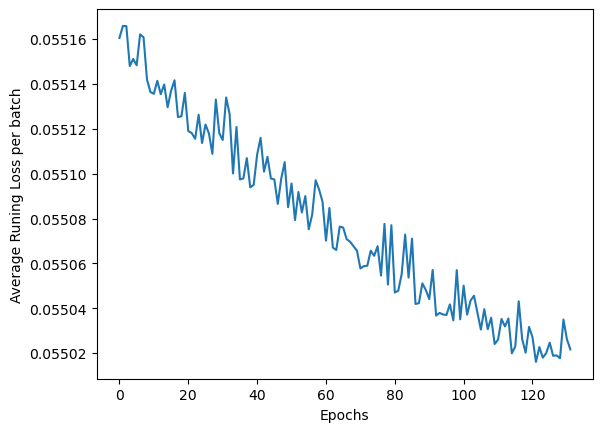

In [24]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [26]:
torch.save(final_model, 'model_100206_7g_04.pt')